### Quantified Self Project: 
# Personal Flying and Working Correlations 
by Jackie Ramsey  
CPSC 222, Fall 2021

## Project Domain:  
My project domain is aviation, more specifically flying data. I am interested in this domain because I am a pilot and am working on my certifications. When I am home, I also work at the flight school that I learn at. I chose this domain because I was interested in the correlation between my flying hours data and my work hours data that I have been collecting this past summer. 

### Dataset:
* flying_logbook.csv
    * Date
    * Total Hours - total hours flying per day
    * Dual Received - hours flying with instructor
    * Pilot in Command - hours flying without instructor
    * Day - hours flying during day
    * Night - hours flying during night
    * Cross-Country - hours flying a distance further than 25nm from departure point
    * Instrument - hours flying using instruments
    * Day Landings - amount of landings during the day
    * Night Landings - amount of landings during the night
* work_hours.csv
    * Date
    * Work - if i worked (yes/no)
    * Work Hours - total hours of work

### Classify
* predict if I flew or not on a certain day
*  whether there will be a positive correlation between the dataset
*  whether there will be a strong negative correlation between the dataset
* if there is a relationship between work days and fly days

### Potential Impacts
Potential impacts include but are not limited to determining whether or not you can get a job, pass an exam, or have the ability to fly a plane in general.

### Stakeholders
* flight instructor
* designated pilot examiners
* boss or hiring 

## Data Analysis
* merge data
* clean data
* data aggregation
* visualizations
* hypothesis tests

In [1]:
from numpy.core.fromnumeric import mean
import pandas as pd
from pandas.io.parsers import read_csv
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as stats
import utils

# load data into DataFrame
flying_logbook = pd.read_csv("flying_logbook.csv")
work_hours = pd.read_csv("work_hours.csv")

flying_logbook_df = pd.DataFrame(flying_logbook)
work_hours_df = pd.DataFrame(work_hours)

In [2]:
# merge data on "Date"
merge_df = flying_logbook_df.merge(work_hours_df, on="Date")
merge_df = pd.DataFrame(merge_df)

### Clean Data
* remove rows where i do not work or fly on that day
* add column that says whether or no I fly
* add column that says whether I fly and work on that day

In [3]:
# clean data 
work_or_flying = []  # column where either work or flew that day
flying = []   # column where flew that day

# go through each date and check dif cases
for i in range(len(merge_df)):
    # neither worked or flew
    if merge_df.at[i, "Work"] == "No" and merge_df.at[i, "Total Hours"] == 0:
        work_or_flying.append("NaN")
        flying.append("NaN")
    # flew and work
    elif merge_df.at[i, "Work"] == "Yes" and merge_df.at[i, "Total Hours"] != 0:
        work_or_flying.append("Yes")
        flying.append("Yes")
    else:
        work_or_flying.append("No")
        # no work, yes fly
        if merge_df.at[i, "Work"] == "No" and merge_df.at[i, "Total Hours"] != 0:
            flying.append("Yes")
        else:
            flying.append("No")

# assign to columns
merge_df["Fly"] = flying
merge_df["Fly and Work"] = work_or_flying

# drop rows where neither work or flying
for i in range(len(work_or_flying)):
    if work_or_flying[i] == "NaN":
        merge_df = merge_df.drop(i)

# reset index and send cleaned data to .csv
merge_df.reset_index(inplace=True)
merge_df = merge_df.drop("index", axis=1)
merge_df.to_csv("merge_cleaned.csv")

Challenges:
It was difficult to find an efficient method of sorting the flying and work data so I could pull the non working and non flying rows out of the dataset.

### Aggregation
* group by
    * whether worked or not
* split, apply, combine
    * Flight lessons (dual received) on days I also worked

In [4]:
# group by Work
work_df = merge_df.groupby("Work")

# split, apply, combine
# find average flying time
daily_hours_ser = pd.Series(dtype=float)
daily_hours_ser = work_df["Dual Received"].mean()
print(daily_hours_ser)

Work
No     1.922222
Yes    0.738462
Name: Dual Received, dtype: float64


According to the aggregation methods, I took flight lessons more when I do not have work then when I did have work. This could be due to time available and scheduling conflicts

### Visualizations

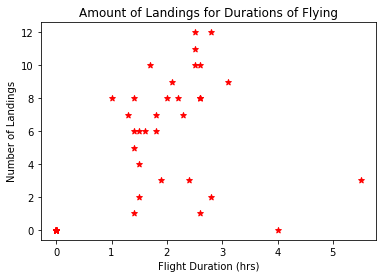

In [5]:
# scatter plot of amount of landings per flight
plt.figure()
y1 = merge_df["Day Landings"].squeeze()
x1 = merge_df["Total Hours"].squeeze()
plt.scatter(x1, y1, color="red", marker="*")
plt.title("Amount of Landings for Durations of Flying")
plt.xlabel("Flight Duration (hrs)")
plt.ylabel("Number of Landings")
plt.show()

According to the scatter plot, there is a higher concentration of the amount of landings I do during a flight around 1-3 hours. This could be due to the type of flying I am doing. Short and long flights are usually for sole travel from point a to point b. Whereas mid length flights are often practice and lessons.

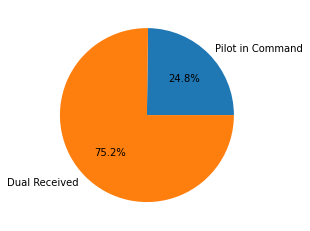

In [6]:
# pi chart of pic or dual
plt.figure()
x = merge_df["Pilot in Command"].squeeze()
y = merge_df["Dual Received"].squeeze()
xbar = mean(x)
ybar = mean(y)
arr = [xbar, ybar]
label_types = ["Pilot in Command", "Dual Received"]
plt.pie(arr, labels=label_types, autopct="%1.1f%%")
plt.show()

According to the pie chart, I did about 3x more lessons than casual flying.  This shows that I focused more on lessons this summer than casual/fun flying.

### Statistical Hypotheses

Do I fly more on days I have work or days that I do not have work?  
two sample independant t test

Step 1:  
$H_0$: $ flyonly hrs > flyandwork hrs$  
$H_1$: $ flyonly hrs \leq flyandwork hrs$  

Step 2:  
Level of significance: $\alpha$ = 0.05 

Step 3:  
$s_p^2 = \frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2}$  
$t=\frac{\overline{X_1} - \overline{X_2}}{\sqrt{s_p^2(\frac{1}{n_1}+\frac{1}{n_2})}}$  
degrees of freedom: $df = n1 + n2 - 2$ 

Step 4:  
p-value/2: $0.373$  

Step 5:  
Since, $0.373 < 0.05$ is not true, then we do not reject H0  

In [7]:
both = []
flyonly = []
for i in range(len(merge_df)):
    if merge_df.at[i, "Fly and Work"] == "Yes":
        both.append(merge_df.at[i, "Total Hours"])
    if merge_df.at[i, "Fly and Work"] == "No" and merge_df.at[i, "Fly"] == "Yes":
        flyonly.append(merge_df.at[i, "Total Hours"])
both = pd.Series(both)
flyonly = pd.Series(flyonly)

n1 = len(flyonly)
n2 = len(both)
df = n1 + n2 -2

sp2 = ((n1 - 1) * flyonly.std() ** 2 + (n2 - 1) * both.std() ** 2) / df
t = (flyonly.mean() - both.mean()) / np.sqrt(sp2 * (1 / n1 + 1 / n2))
t, p = stats.ttest_ind(flyonly, both)
print("sp2:", sp2)
print("t:", t)
print("p/2:", p/2)

if p/2 < 0.05:
    print("Reject H0")
else:
    print("Do not reject H0")

sp2: 0.8012354497354497
t: 0.32594622369796916
p/2: 0.373363917499927
Do not reject H0


Are instrument flights longer than non instrument flights?  
two sample independant t test

Step 1:  
$H_0$: $ instrumen hrs > non instrument hrs$  
$H_1$: $ instrument hrs \leq non instrument hrs$  

Step 2:  
Level of significance: $\alpha$ = 0.05 

Step 3:  
$s_p^2 = \frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2}$  
$t=\frac{\overline{X_1} - \overline{X_2}}{\sqrt{s_p^2(\frac{1}{n_1}+\frac{1}{n_2})}}$  
degrees of freedom: $df = n1 + n2 - 2$ 

Step 4:  
p-value/2: $0.0003$  

Step 5:  
Since, $0.0003 < 0.05$ is true, then we reject H0  

In [8]:
ifr = []
vfr = []
for i in range(len(merge_df)):
    if merge_df.at[i, "Instrument"] != 0:
        ifr.append(merge_df.at[i, "Total Hours"])
    else:
        vfr.append(merge_df.at[i, "Total Hours"])
ifr = pd.Series(ifr)
vfr = pd.Series(vfr)

n1 = len(ifr)
n2 = len(vfr)
df = n1 + n2 -2

# Step 4
sp2 = ((n1 - 1) * ifr.std() ** 2 + (n2 - 1) * vfr.std() ** 2) / df
t = (ifr.mean() - vfr.mean()) / np.sqrt(sp2 * (1 / n1 + 1 / n2))
t, p = stats.ttest_ind(ifr, vfr)
print("sp2:", sp2)
print("t:", t)
print("p/2:", p/2)

# Step 5
if p < 0.05:
    print("Reject H0")
else:
    print("Do not reject H0")

sp2: 1.3697951048951051
t: 3.5928014951617993
p/2: 0.0003494370267483079
Reject H0


## Classification
* kNN
    * predict if I flew or not on a certain day
* linear regression
    * find correlation between landings and lessons
        * hypothesis: there will be a positive correlation between the dataset
    * find correlation between time worked and flying
        * hypothesis: there will be a strong negative correlation between the dataset


In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = merge_df.drop(columns=["Date","Work","Fly and Work","Fly"])
y = merge_df["Fly"]

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

knn_clf = KNeighborsClassifier(n_neighbors=3, metric="euclidean")
knn_clf.fit(X_train, y_train)

y_predicted = knn_clf.predict(X_test)
print(y_predicted)

['Yes' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'No' 'No' 'No'
 'No' 'No']


From this kNN test we can conclude that "Yes", I mostly likely flew on a certain day

m: 0.204143375132195 b: 0.36733645565795503 r: 0.6346422707776496


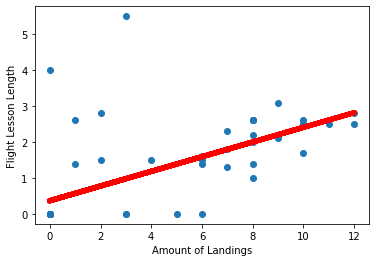

In [10]:
import scipy.stats as stats

x = merge_df["Day Landings"]
y = merge_df["Dual Received"]
m, b, r, p_val, std_err = stats.linregress(x, y)
print("m:", m, "b:", b, "r:", r)

plt.scatter(x, y)
plt.plot(x, m*x+b, c="red", lw=5)
plt.xlabel("Amount of Landings")
plt.ylabel("Flight Lesson Length")
plt.show()

In [11]:
m, b, r, p_val, std_err = stats.linregress(x, y)
print("m:", m, "b:", b, "r:", r)

test_instance = 100
y_predicted = m * test_instance + b
print("prediction:", y_predicted, "residual (error): ", 2 * test_instance - y_predicted)

print("R^2", r * r)

m: 0.204143375132195 b: 0.36733645565795503 r: 0.6346422707776496
prediction: 20.781673968877456 residual (error):  179.21832603112256
R^2 0.4027708118578115


The correlation of landings and lessons has positive linear correlation of 0.402. As the hours of flying increased, so did the amount of landings I did. This could be due to time available to perform landings.

m: -0.2096884672115269 b: 2.1171569338832343 r: -0.5060783186839283


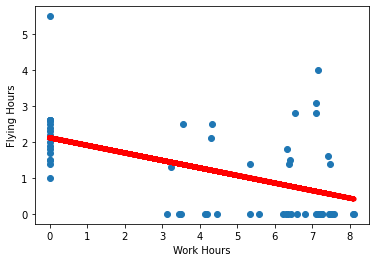

In [12]:
y = merge_df["Total Hours"]
x = merge_df["Work Hours"]
m, b, r, p_val, std_err = stats.linregress(x, y)
print("m:", m, "b:", b, "r:", r)

plt.scatter(x, y)
plt.plot(x, m*x+b, c="red", lw=5)
plt.ylabel("Flying Hours")
plt.xlabel("Work Hours")
plt.show()

In [13]:
m, b, r, p_val, std_err = stats.linregress(x, y)
print("m:", m, "b:", b, "r:", r)

test_instance = 100
y_predicted = m * test_instance + b
print("prediction:", y_predicted, "residual (error): ", 2 * test_instance - y_predicted)

print("R^2", r * r)

m: -0.2096884672115269 b: 2.1171569338832343 r: -0.5060783186839283
prediction: -18.851689787269457 residual (error):  218.85168978726946
R^2 0.25611526464195167


The correlation of work and flying time has a weaak negative linear relationship. As flying hours increased, work hours decreased. This would be due to time available within a day to do either.

## Conclusion
Summary:  
The data set I used for the kNN model was all numerical columns and whether or not I flew based on the given data. The outcome of this prediction given 3 nearest neighbors, is tha I do fly on a given day. For my linear regression data, I wanted to see the correlation between my flying hours and work hours/amount of landings. There was not a very strong correlation between the work and flying hours as I predicted. However, there was a stronger correlation between the amount of landings and flying hours.

Improvements:  
In order to improve my classification approaches, I could take out rows that are 0 aka I did not fly since there are quite a few instances of this case. That would cause the mean to be more accurate because it would not be weighted by these. 

Impacts:
Potential impacts for the stakeholders of this data would vary depending on the use of this data. If this was aimed towards a career and used for a resume or hiring design, it would be important to see how they handle factors such as bad whether conditions(instrument) etc. For examiners, it would help determine if they have satisfied the requirements for passing an exam. For flight instructors, this would allow them to create plans on what to focus on and move on from.

Sources: notes from class
